In [1]:
%cd ~/desktop/RNA/casp16
casp_id = "M1293"
pdb_dir=f"./datasets/casp16/{casp_id}/zdock/pdb"

/Users/sumishunsuke/Desktop/RNA/casp16


# energy (R1293, M1293で同じ)

In [2]:
!ls {pdb_dir}/*pdb | wc -l

!python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir} --cpu 6

    1000
['zdock.S_000485-top1.pdb', 'zdock.S_000815-top1.pdb', 'zdock.S_000484-top1.pdb', 'zdock.S_000814-top1.pdb']


In [3]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
all_pdb_ids[:3]

['S_000001', 'S_000002', 'S_000003']

In [4]:
# re-proc

all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
print(len(all_pdb_ids))

energies = {}
unprocessed = []
for pdb_id in all_pdb_ids:
    f = f"{pdb_dir}/zdock.{pdb_id}-top1.briq.out"
    try:
        with open(f) as fh: lines = fh.readlines()
        energies[f] = float(lines[-1].strip().replace("Energy: ", ""))
    except:
        unprocessed.append(pdb_id)

print(len(energies), len(unprocessed))

1000
1000 0


In [21]:
# import sys
# sys.path.append("./")
# from src.score import RNA_BRiQ
# from multiprocessing import Pool

# with Pool(3) as pool:
#     results = pool.map(
#         RNA_BRiQ.process_pdb_file_eval,
#         [f"{pdb_dir}/zdock.{pdb_id}-top1.pdb" for pdb_id in unprocessed]
#         )

# energy書き出し

In [6]:
out_files = !ls {pdb_dir}/*briq.out

pdb_energy = {}
for out in out_files:
    with open(out) as fh: 
        lines = fh.readlines()
    energies = float(lines[-1].strip().replace("Energy: ", ""))
    basename = out.split("/")[-1].replace("-top1.briq.out", "").replace("zdock.", "")
    pdb_energy[basename] = energies


# pdb_energy["S_000001"]

import pandas as pd
df_briq = pd.DataFrame(pdb_energy.items(), columns=["pdb", "BRiQscore"])
df_briq.head(3)

,pdb,BRiQscore
0,S_000001,-109.946
1,S_000002,-150.769
2,S_000003,-102.537


In [7]:
df_zdock = pd.read_csv(f"{pdb_dir}/ZDOCKscore.csv", header=None)
df_zdock.columns = ["pdb", "ZDOCKscore"]
print(df_zdock.head(3))

                       pdb  ZDOCKscore
0  zdock.S_000001-top1.pdb    3023.405
1  zdock.S_000002-top1.pdb    3127.552
2  zdock.S_000003-top1.pdb    2971.157


In [10]:
import pandas as pd 
df_zdock = pd.read_csv(f"{pdb_dir}/ZDOCKscore.csv", header=None)
df_zdock.columns = ["pdb", "ZDOCKscore"]
df_zdock["pdb"] = [f.split("/")[-1].replace("zdock.", "").replace("-top1.pdb", "") for f in df_zdock["pdb"]]
df = pd.merge(df_briq, df_zdock, on="pdb")
print(df.shape)
print(df.head())


df.to_csv(f"{pdb_dir}/{casp_id}_scores.csv", index=False)

(1000, 3)
        pdb  BRiQscore  ZDOCKscore
0  S_000001   -109.946    3023.405
1  S_000002   -150.769    3127.552
2  S_000003   -102.537    2971.157
3  S_000004   -124.301    3082.959
4  S_000005   -144.826    2847.113


(439, 3)


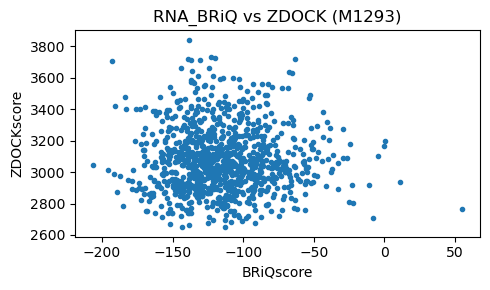

In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")


n_take = 250
df_briq_top = df_scores.sort_values("BRiQscore", ascending=True).head(n_take)
df_zdock_top = df_scores.sort_values("ZDOCKscore", ascending=True).tail(n_take)
df_both_top = pd.concat([df_briq_top, df_zdock_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df_scores["BRiQscore"], df_scores["ZDOCKscore"], marker=".")
# plt.scatter(df_both_top["BRiQscore"], df_both_top["ZDOCKscore"], marker=".", color="orange", label=f"Top {n_take}")
# plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("ZDOCKscore")
plt.title(f"RNA_BRiQ vs ZDOCK ({casp_id})")

print(df_both_top.shape)
plt.tight_layout()
plt.savefig(f"{pdb_dir}/{casp_id}_scores.pdf")

In [14]:
# for i,row in df_both_top.iterrows():
#     pdb = row["pdb"]
#     !cp {pdb_dir}/zdock.{pdb}-top1.pdb datasets/casp16/M1282/zdock/top_pdb